**Table of contents**<a id='toc0_'></a>    
- [Visibility](#toc1_)    
  - [I. Usability elements](#toc1_1_)    
    - [I.1 Angle classes](#toc1_1_1_)    
    - [I.2 Interpolation](#toc1_1_2_)    
  - [II. Time](#toc1_2_)    
    - [II.1 Time correction](#toc1_2_1_)    
    - [II.2 Class for time and date](#toc1_2_2_)    
    - [II.3 Julian Day](#toc1_2_3_)    
    - [II.4 Sidereal Time](#toc1_2_4_)    
      - [II.4.1 Greenwich HA](#toc1_2_4_1_)    
      - [II.4.2 LST](#toc1_2_4_2_)    
  - [III. Trajectory along the sky](#toc1_3_)    
    - [III.1 Coordinates](#toc1_3_1_)    
    - [III.2 Compute trajectory](#toc1_3_2_)    
      - [III.2.1 Precession](#toc1_3_2_1_)    
      - [III.2.2 Nutation](#toc1_3_2_2_)    
      - [III.2.3 Refraction](#toc1_3_2_3_)    
      - [III.2.4 Motion along the sky](#toc1_3_2_4_)    
    - [III.2.5 Transit,](#toc1_3_3_)    
  - [IV. Sun](#toc1_4_)    
    - [IV.I Twilight](#toc1_4_1_)    
  - [V. Moon](#toc1_5_)    
    - [V.I Moon Phases](#toc1_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Visibility](#toc0_)

## <a id='toc1_1_'></a>[I. Usability elements](#toc0_)

Import required packages 

In [1]:
## required packages
import os.path as ph
from os import getcwd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

PROJECT_FOLDER = ph.split(getcwd())[0]
DATA_FOLDER = ph.join(PROJECT_FOLDER,'data')


In [2]:
def get_data(filename: str, unpack: bool = True, delimiter: str = ',', message: bool = False) -> np.ndarray:
    DATA_FILE = ph.join(DATA_FOLDER,filename)
    if message:
        print('> Open file: ' + DATA_FILE)
    ext = filename[-3:]
    if ext == 'csv':
        from pandas import read_csv
        data = read_csv(DATA_FILE, delimiter=delimiter).to_numpy().transpose()
    elif ext == 'txt':
        data = np.loadtxt(DATA_FILE,unpack=unpack)
    else: raise Exception(f'.{ext} is not allowed!\nOnly .txt or .csv files')
    return data

def import_data(filename, sel: int | slice = slice(None), delimiter: str =',', sep: str = ':'):
    names, ras, decs, muas, muds = get_data(filename,delimiter=delimiter)
    
    prmts = []
    for i in range(len(names)):
        alpha = ras[i]
        delta = decs[i]
        mua = muas[i]
        mud = muds[i]

        ras[i] = [alpha[0],[float(val) for val in alpha[1:].split(sep)]]
        decs[i] = [delta[0],[float(val) for val in delta[1:].split(sep)]]
        
        mua = float(mua) if mua != 'None' else None
        mud = float(mud) if mud != 'None' else None
        prmts += [[mua,mud]]
    
    return names[sel], ras[sel], decs[sel], prmts[sel]


### <a id='toc1_1_1_'></a>[I.1 Angle classes](#toc0_)

To handle the different formats in which one can express the value of an angle on celestial sphere (radiants, degrees, hours), two classes of object are defined. These keep the value of an angle in different units and provide some usefull function to convert from one format to an other.

In [3]:
class Angles():
    """Class to handle with angles in degrees or radiants.
    
    The class takes the value of an angle in deg or rad,
    converts one in other and stored the values.

    The attributes of the class are:

    :ivar rad: the value of the angle in radiants
    :vartype rad: float | None
    :ivar deg: the value of the angle in deg
    :vartype deg: float    
    :ivar lim: the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `Angles` variable
        (`self.deg = None` and `self.rad = None`), through the command `Angles(None)`. 

    :Example:

    >>> ang = Angles()
    """

    #: a dictionary to pass from string symbol to integer and vice versa
    strsign = { '+' :  1,
                '-' : -1,
                 1  : '+',
                -1  : '-' }

    @staticmethod
    def decimal(ang: np.ndarray | list) -> float:
        """Function to convert a list angle
        [val, val, val.val] in a float 
        val.val 

        :param ang: angle array value in deg or hms
        :type ang: np.ndarray | list
        
        :return: angle float value
        :rtype: float
        """
        if sum(ang) == 0: return 0
        else: return ang[0] + ang[1]/60 + ang[2]/3600
    
    @staticmethod
    def deg_to_rad(deg: float) -> float:
        """Function to convert deg in rad

        :param deg: angle in deg
        :type deg: float

        :return: value in rad
        :rtype: float
        """
        # computing radiants
        rad = deg * pi / 180
        return rad

    @staticmethod
    def rad_to_deg(rad: float) -> float:
        """Function to convert rad in deg

        :param rad: value in rad
        :type rad: float
        
        :return: angle in deg
        :rtype: float
        """
        # computing degrees
        deg = rad * 180 / pi
        return deg

    @staticmethod
    def std_format(deg, lim) -> list:
        """Function to adjust format of a list angle in deg or hms.

        The wanted format is: [`sign`, [deg (<`lim`), pp (<60), ss.ss (<60)]]
          
        :return: correct format for the angle value
        :rtype: list
        """
        # getting value in deg
        ang = deg
        if ang == 0.:
            return ['+',np.zeros(3,dtype=int)]
        else:
            # taking the lim
            lim = lim
            # taking the sign as a str
            sign = Angles.strsign[np.sign(ang)]
            # taking the absolute value
            ang = abs(ang)
            # edge condition
            if ang > lim:
                ang -= lim * (ang // lim)
            # degrees
            val = [np.trunc(ang).astype(int)]
            # primes
            val += [np.trunc(ang % 1 * 60).astype(int)]
            # seconds
            val += [round(ang % 1 * 60 % 1 * 60,4)]
            return [sign, np.array(val)]
    
    @staticmethod
    def str_angle(deg: float, rad: float, lim: int, sel: str = 'all', unit: bool = False) -> str:
        """Function to print the value of an angle
        
        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            * `sel = 'all'`: print value in all units
            * `sel = 'deg'`: print value in deg
            * `sel = 'rad'`: print value in rad

        :param sel: to select in which unit printing the angle, defaults to 'all'
        :type sel: str, optional

        :return: the string with the values
        :rtype: str

        :raise: 
        """
        # adjusting the format in deg
        deg = Angles.std_format(deg,lim)
        # collecting string for each unit
        dd, mm, ss = deg[1]
        deg_str = deg[0]+f'[{dd:.0f}, {mm:.0f}, {ss:.4f}]'
        rad_str = f'{rad/pi} * pi'
        
        if unit:
            deg_str += ' deg'
            rad_str += ' rad'

        if sel == 'deg': return deg_str
        elif sel == 'rad': return rad_str
        elif sel == 'all': return 'deg =\t' + deg_str + '\nrad =\t' + rad_str
        else: raise Exception(f"-> Error in `sel` parameter!\nsel = {sel} is not allowed\nRead the documentation for correct values of the parameter")

    def __init__(self, ang: float | list | None, unit: str, lim: int = 360) -> None:
        """Constructor of the class

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg and rad. 

        :param ang: angle value
        :type ang: float | list | None
        :param unit: unit of angle value, like 'deg' or 'rad'
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to 360
        :type lim: int, optional
        """
        # setting lim
        self.lim = lim
        # condition for a null angle
        if ang is None:
            self.deg = None
            self.rad = None
        # value in radiants
        elif unit == 'rad':
            self.rad = ang
            self.deg = Angles.rad_to_deg(ang)
        # value in degrees
        elif unit == 'deg':
            # list format
            if type(ang) == list:
                # getting the sign
                sign = Angles.strsign[ang[0]]
                self.deg = Angles.decimal(ang[1])*sign
            else:
                self.deg = ang
            self.rad = Angles.deg_to_rad(self.deg)

    def copy(self):
        return Angles(self.deg,'deg',self.lim)

    def print_angle(self, sel: str = 'all', unit: bool = False) -> list[str] | str:
        ang = self.copy()
        if type(ang.deg) != np.ndarray:
            ang.deg = [ang.deg]
            ang.rad = [ang.rad]
        deg = ang.deg
        rad = ang.rad
        str_list = []
        for i in range(len(deg)):
            str_res = ''
            if sel == 'all' and len(deg) > 1:
                str_res += f'ang {i}:\n'
            str_res += Angles.str_angle(deg[i], rad[i], ang.lim, sel=sel, unit=unit)
            str_list += [str_res]
        
        if len(deg) == 1:
            str_list = str_res
        return str_list


    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle
        :type angle: Angles

        :return: sum of the angles
        :rtype: Angles
        """
        if isinstance(angle, (int,float)):
            angle = Angles(angle,'deg',self.lim)
        # check for edges
        if self.lim != angle.lim:
            print(f'\n!warning: you are summing angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return Angles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle
        :type angle: Angles

        :return: subtraction of the angles
        :rtype: Angles
        """
        if isinstance(angle, (int,float)):
            angle = Angles(angle,'deg',self.lim)
        if self.lim != angle.lim:
            print(f'\n!warning: you are subtracting angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        subrad = self.rad - angle.rad
        return Angles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int

        :return: angle-number product
        :rtype: Angles
        """
        return Angles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        return self * -1



class HAngles(Angles):
    """This is essentially the same class as :class: `Angles`, keeping in account 
    the description of an angle in [hours, minutes, seconds] format.

    The attributes are:

    :ivar rad: from :class: `Angles`; the value of the angle in rad 
    :vartype rad: float
    :ivar deg: from :class: `Angles`; the value of the angle in deg 
    :vartype deg: float    
    :ivar deg: the value of the angle in hours
    :vartype deg: float  
    :ivar lim: from :class: `Angles`; the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `HAngles` variable
        (`self.deg = None`, `self.rad = None` and `self.hms = None`), through the 
        command `HAngles(None)`. 
    """

    @staticmethod
    def deg_to_hms(deg: float) -> float:
        """Function to convert deg in hms

        1 hour = 15 degrees

        :param deg: angle in deg
        :type deg: float

        :return: angle in hms
        :rtype: float
        """
        hms = deg / 15
        return hms
    
    @staticmethod
    def hms_to_deg(hms: float) -> float:
        """Function to convert hms in deg

        1 hour = 15 degrees

        :param hms: angle in hms
        :type hms: float

        :return: angle in deg
        :rtype: float
        """
        deg = hms * 15
        return deg
    
    @staticmethod
    def rad_to_hms(rad: float) -> float:
        """Function to convert rad in hms

        It pass through the `rad_to_deg()` and
        `deg_to_hms()` functions

        :param rad: angle value in rad
        :type rad: float

        :return: angle in hms
        :rtype: float
        """
        deg = Angles.rad_to_deg(rad)
        hms = HAngles.deg_to_hms(deg)
        return hms
    
    @staticmethod
    def hms_to_rad(hms: float) -> float:
        """Function to convert hms in rad

        It pass through the `hms_to_deg()` and
        `deg_to_rad()` functions

        :param rad: angle in hms
        :type rad: float

        :return: angle value in rad 
        :rtype: float
        """
        deg = HAngles.hms_to_deg(hms)
        rad = Angles.deg_to_rad(deg)
        return rad

    @staticmethod
    def str_angle(deg: float, rad: float, hms: float, lim: int, sel: str = 'all', unit: bool = False) -> str:
        """Function to print the value of an angle
        (inherited from :class: `Angles`)

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            - `sel = 'all'`: print value in all units
            - `sel = 'deg'`: print value in deg
            - `sel = 'rad'`: print value in rad
            - `sel = 'hms'`: print value in hms

        :param sel: to select in which unit printing the angle, defaults to 'all'
        :type sel: str, optional

        :return: the string with the values
        :rtype: str
        """
        # adjusting the format in hms
        hms = Angles.std_format(hms,lim/15)
        # collecting string for each unit
        hh, mm, ss = hms[1]
        hms_str = hms[0]+f'[{hh:.0f}, {mm:.0f}, {ss:.4f}]'

        if unit:
            hms_str += ' hms'
        
        if sel == 'hms': return hms_str
        elif sel == 'all': return  Angles.str_angle(deg, rad, lim, sel=sel, unit=unit) + '\nhms = \t' + hms_str
        else: return Angles.str_angle(deg, rad, lim, sel=sel, unit=unit)
    
    def __init__(self, ang: float | list | None, unit: str, lim: int = 360):
        """Constructor of the class (inherited from :class: `Angles`)

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg, rad and hms. 

        :param ang: angle value
        :type ang: float | list
        :param unit: unit of angle value, like 'deg' or 'rad'
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to 360
        :type lim: int, optional
        """
        # `Angles.__init__()` function
        super().__init__(ang, unit, lim)
        # condition for a null angle 
        if ang is None:
            self.hms = None
        # angle in hms
        elif unit == 'hms':
            # list format
            if type(ang) == list:
                # taking the sign
                sign = Angles.strsign[ang[0]]
                self.hms = Angles.decimal(ang[1])*sign
            else:
                self.hms = ang
            self.deg = HAngles.hms_to_deg(self.hms)
            self.rad = HAngles.hms_to_rad(self.hms)
        # angle in rad or deg
        else:
            self.hms = HAngles.deg_to_hms(self.deg)

    def copy(self):
        return HAngles(self.deg,'deg',self.lim)
    
    def print_angle(self, sel: str = 'all', unit: bool = False) -> list[str] | str:
        ang = self.copy()
        if type(ang.deg) != np.ndarray:
            ang.deg = [ang.deg]
            ang.rad = [ang.rad]
            ang.hms = [ang.hms]
        deg = ang.deg
        rad = ang.rad
        hms = ang.hms
        str_list = []
        for i in range(len(deg)):
            str_res = ''
            if sel == 'all' and len(deg) > 1:
                str_res += f'ang {i}:\n'
            str_res += HAngles.str_angle(deg[i], rad[i], hms[i], ang.lim, sel=sel, unit=unit)
            str_list += [str_res]
        if len(deg) == 1:
            str_list = str_res
        return str_list
    
    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle
        :type angle: Angles

        :return: sum of the angles
        :rtype: Angles
        """
        if type(angle) == float or type(angle) == int:
            angle = HAngles(angle,'deg',self.lim)
        # check for edges
        if self.lim != angle.lim:
            print('-> Warning: you are summing angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum
        sumrad = self.rad + angle.rad
        return HAngles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle
        :type angle: HAngles

        :return: subtraction of the angles
        :rtype: HAngles
        """        
        if type(angle) == float or type(angle) == int:
            angle = HAngles(angle,'deg',self.lim)
        # check for edges
        if self.lim != angle.lim:
            print(f'-> Warning: you are subtracting angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the subtaction
        subrad = self.rad - angle.rad
        return HAngles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int

        :return: angle-number product
        :rtype: HAngles
        """
        return HAngles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        return self * -1



# defining some fixed angles
RIGHT = Angles( 90.,'deg')
FLAT  = Angles(180.,'deg')
ROUND = Angles(360.,'deg')


### <a id='toc1_1_2_'></a>[I.2 Interpolation](#toc0_)

It's possible only if III diff $\sim$ 0 when you have more than 3 points

In [4]:
def interpole_three(values: list | np.ndarray, centre: float | None = None, xvalues: list | np.ndarray | None = None, val: str | None = None,**kargs) -> float | tuple[float, dict]:
    """_summary_

    :param values: _description_
    :type values: list | np.ndarray
    :param centre: _description_, defaults to None
    :type centre: float | None, optional
    :param xvalues: _description_, defaults to None
    :type xvalues: list | np.ndarray | None, optional
    :param val: _description_, defaults to None
    :type val: str | None, optional
    :raises Exception: _description_
    :raises Exception: _description_
    :raises Exception: _description_
    :raises Exception: _description_
    :return: _description_
    :rtype: float | tuple[float, dict]
    """
    if 'warning' in kargs.keys():
        warning = kargs['warning']
    else:
        warning = True
    # storing dimension and values
    dim = len(values)
    sample = np.copy(values)
    # condition for more than three values
    if dim > 3:
        # central value is necessary
        if centre == None: raise Exception('Error in central value!\n You have to pass the central value for interpolation')
        # also x values are necessary
        if len(xvalues) == 0: raise Exception('Error in `xval`!\n You have to pass x values for interpolation')
        # checking the magnitude of the third difference
        diff = np.diff(np.diff(np.diff(sample)))
        maxdiff = diff.max()
        if np.abs(maxdiff) > 3: 
            raise Exception(f'Error in interpolation!\nThe third difference is not negligible: {maxdiff}')
        # computing the index of the central value
        idx = (np.abs(xvalues - centre)).argmin()
        # correction for extrema
        if idx == dim-1: idx -= 1
        elif idx == 0: idx += 1
        # cutting the sample to have only three
        # centered in central value
        sample = sample[idx-1:idx+2]
        xvalues = xvalues[idx-1:idx+2]
    # checking at least three values are passed
    elif dim < 3: raise Exception('!Error in length!\nInterpolation needs three points at least')
    # getting the central values
    centre_val = sample[1]
    # computing differences
    a, b = np.diff(sample)
    c = b - a
    if centre != None:
        x2 = xvalues[1]
        # computing the interpolation factor
        n = (centre - x2)/np.abs(x2-xvalues[0])
        # computing the interpolated value
        result = centre_val + n/2 * (a + b + n*c) 
    else:
        if warning: print(': No interpolation was done: parameter `centre` set to `None`')
        result = None

    # condition to compute other quantities
    if val != None:
        # defining the dictionary for additional values
        dval = {}
        # condition to compute extrema through iterpolation
        if val == 'ym' or val == 'all':
            dval['ym'] = centre_val - (a+b)**2/(8*c)
            dval['nm'] = - (a+b) / (2*c)
        # condition to compute where function is null through iterpolation
        if val == 'n0' or val == 'all':
            # recursive method  
            n0 = 0
            cnt = 0     # control variable
            while True:
                dn0 = -(2*centre_val + n0*(a+b+c*n0))/(a+b+2*c*n0)
                n0 += dn0
                cnt += 1
                if np.abs(dn0) < 1e-6:
                    break
                # control condition to prevent a Stack Overflow error
                if cnt > 20 and warning:
                    n0 = None 
                    print('Algorithm did not converge for n0!')
                    break
            dval['n0'] = n0 
        # appending the dictionary to the result
        result = (result, dval)
    return result

x = [26.,27.,28.]
y = [-28*60-13.4,6*60+46.3,38*60+23.2]
print(y)
yi, vals = interpole_three(y,val='n0')

print(f"Interpolated: {yi}\nn0 = {vals['n0']}")

del x,y,yi,vals

[-1693.4, 406.3, 2303.2]
: No interpolation was done: parameter `centre` set to `None`
Interpolated: None
n0 = -0.20126729503148005


## <a id='toc1_2_'></a>[II. Time](#toc0_)


### <a id='toc1_2_1_'></a>[II.1 Time correction](#toc0_)

Universal Time (UT) differs from Dynamical Time (TD).

$\Delta T = TD - UT$ 

In [5]:
def time_correction(year: float,**kargs) -> float:
    """Computing the difference between TD and UT

    For years between 1620 and 1998 the 
    difference is computed through 
    interpolation from a data table (see
    `/data/dT_data.csv`)
    
    For years out that range an 
    approximated formula is used, instead

    :param year: year for which computing TD-UT
    :type year: float
    
    :return: TD - UT
    :rtype: float
    """
    # interpolation from data table
    if 1620 <= year <= 1998:
        # name of data file
        filename = 'dT_data.csv'
        # extracting data
        y0, dt0 = get_data(filename)
        # value is already in data
        if year in y0:
            dt = dt0[year == y0][0]
        # computing interpolation
        else:
            dt = interpole_three(dt0,centre=year,xvalues=y0,kargs=kargs)
    # approximated formula
    else:        
        t = (year - 2000)/100
        if year < 948:
            dt = 2177 + 497*t + 44.1*t**2
        else:
            dt =  102 + 102*t + 25.3*t**2
        if 2000 <= year <= 2100: dt += 0.37*(year-2100)
    return dt

year = 1623
print(f'Correction for the year: {year}')
print(f'dT = DT - UT = {time_correction(year)}')

Correction for the year: 1623
dT = DT - UT = 107.5


### <a id='toc1_2_2_'></a>[II.2 Class for time and date](#toc0_)

In [6]:
class Time():

    DAYSEC = 86400.

    @staticmethod
    def seconds(hh: int, mm: int, ss: float) -> float:
        return ss + mm*60 + hh*3600 
    
    @staticmethod
    def hms_form(time: float) -> list:
        ss = np.round(time % 60, 4)
        mm = int((time // 60) % 60)
        hh = int(time // 3600)
        if ss == 60: 
            ss -= 60
            mm += 1
        if mm == 60:
            mm -= 1
            hh += 1
        return [hh,mm,ss]
    
    @staticmethod
    def str_time(time: float, timetype: str) -> str:
        hh,mm,ss = Time.hms_form(time)
        strtime = f'{hh}h'
        if ss != 0.:
            form = lambda x: f'{x:.0f}' if x % 1 == 0 else f'{x:.4f}'
            strtime += f'{mm}m'+form(ss)+'s'
        elif mm != 0.:
            strtime += f'{mm}m'
        return strtime + ' ' + timetype

    def __init__(self, value: list | float | np.ndarray | None = None, timetype: str = 'UT') -> None:
        if value is None: 
            value = 0.0
        elif type(value) == list:
            value = Time.seconds(*value)
        elif type(value) == np.ndarray:
            value = np.copy(value)
        self.val = value
        self.tytime = timetype

    def copy(self):
        return Time(self.val,self.tytime)
    
    def change_time_type(self, year: int, tytime: str, out: str = 'sec'):
        time = self.copy().val
        if tytime != self.tytime:
            if type(year) == np.ndarray:  
                dt = np.array([time_correction(yy) for yy in year])
            else:
                dt = time_correction(year)
            if tytime == 'TD':   time += dt
            elif tytime == 'UT': time -= dt
        if out == 'sec':
            return time
        elif out == 'Time':
            return Time(time,timetype=tytime)

    def minute(self):
        return self.val / 60

    def hour(self):
        return self.val / 3600

    def print_time(self, enum: bool = True) -> list[str] | str:
        time = self.copy()
        if type(time.val) != np.ndarray:
            time.val = np.array([time.val])
        sec = time.val
        str_list = []
        for i in range(len(sec)):
            str_res = ''
            if len(sec) > 1 and enum:
                str_res += f'time {i}:\n'
            str_res += Time.str_time(sec[i], time.tytime)
            str_list += [str_res]
        if len(sec) == 1:
            str_list = str_res
        return str_list
            
    def __add__(self, time):
        sumtime = self.val + time.val
        return Time(sumtime,self.tytime)
    
    def __sub__(self, time):
        subtime = self.val - time.val
        return Time(subtime,self.tytime)
              


class Date():

    # epochs
    J2000 = 2451545.
    B1950 = 2433282.4235
    B1900 = 2415020.3135



    MONTHS = {
        1 : 'January',
        2 : 'February',
        3 : 'March',
        4 : 'April',
        5 : 'May',
        6 : 'June',
        7 : 'July',
        8 : 'August',
        9 : 'September',
        10 : 'October',
        11 : 'November',
        12 : 'December'
    }

    @staticmethod
    def julian_day(year: int | np.ndarray, month: int | np.ndarray, day: float | int | np.ndarray, time: float | np.ndarray, calendar: str = 'Gregorian', MJD: bool = False) -> float:
        """Computing the Julian Day

        One can compute the JD from a date of Gregorian or Julian calendar and also the 
        Modified JD

        From J.,Meeus, *Astronomical Algorithms*, pg. 61. 
        Follow the same notation.

        Same from M., Gallaway, *An Introduction to Observational Astrophysics*, 
        pg. 41.

        Different in *Explatatory supplement to the Astronomical Almanac*, pg. 604

        :param year: year
        :type year: int
        :param month: month
        :type month: int
        :param day: day 
        :type day: float
        :param calendar: kind of chosen calendar, defaults to 'Gregorian'
        :type calendar: str, optional
        :param MJD: set `True` to have the Modified JD, defaults to False
        :type MJD: bool, optional

        :return: Julian Day
        :rtype: float

        :raise: 
        """
        if type(year) != np.ndarray:
            year = np.array([year])
            month = np.array([month])
            day = np.array([day])
            time = np.array([time])
        day = day.astype(float)
        day += time/Time.DAYSEC
        year  = np.where(month <= 2, year-1, year)
        month = np.where(month <= 2, month+12, month)

        JD = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day - 1524.5

        if calendar == 'Gregorian':
            A = np.floor(year / 100)
            B = (2 - A + np.floor(A / 4)) 
            JD += B
        elif calendar != 'Julian':
            raise Exception("!ERROR in chosen calendar!\nFunction accepts only the string:\n\t- 'Gregorian'\n\t- 'Julian'")
        
        if MJD:
            JD -= 2400000.5

        if len(JD) == 1:
            JD = JD[0]
        return JD

    @staticmethod
    def calendar_date(JD: float | np.ndarray, timetype: str = 'UT', epoch: str ='J2000.0'):
        """Computing the calendar date from JD

        Different in *Explatatory supplement to the Astronomical Almanac*, pg. 605  

        :param JD: Julian Day
        :type JD: float

        :return: calendar date in [year, month, day.decimal]
        :rtype: list
        """
        if type(JD) != np.ndarray:
            JD = np.array([JD])
        
        JD = np.copy(JD)        
        JD += 0.5
        F, Z = np.modf(JD)
        alpha = np.floor((Z-1867216.25)/36524.25)
        A = np.where(Z < 2299161, Z, Z + 1 + alpha - np.floor(alpha / 4))
        B = A + 1524
        C = np.floor((B-122.1)/365.25)
        D = np.floor(365.25 * C)
        E = np.floor((B-D) / 30.6001)
        
        day = B - D - np.floor(30.6001 * E) + F
        month = np.where(E < 14, E-1, E-13).astype(int)
        year = np.where(month > 2, C-4716, C-4715).astype(int)        
        time = (day % 1) 
        day -= time
        if len(year) == 1:
            year  = year[0]
            month = month[0]
            day   = day[0]
            time  = time[0]
        return [year,month,day], Time(time*Time.DAYSEC,timetype=timetype)

    @staticmethod
    def std_format(day: float, time: float) -> str:
        if day % 1 != 0:        
            time += (day % 1)*86400
            day -= (day % 1)
        if time > Time.DAYSEC:
            day += time // Time.DAYSEC
            time -= time // Time.DAYSEC * Time.DAYSEC
        return day, time

    @staticmethod
    def str_date(year: int, month: int, day: int | float) -> str:
        strdate = f'{year:.0f} {Date.MONTHS[month]} {day:.0f}'
        return strdate

    def __init__(self, date: list | None = None, time: list | float | np.ndarray | Time | None = None, jd: float | None = None, timetype: str = 'UT', calendar: str = 'Gregorian', epoch: str = 'J2000.0') -> None:
        if type(time) != Time:
            time = Time(time,timetype)
        
        if (jd is None) and (date is None):
            raise Exception('error')
        elif jd is None:
            if type(time.val) == np.ndarray and type(date[0]) != np.ndarray:
                date = [np.array([dd]*len(time.val)) for dd in date]
            jd = Date.julian_day(*date,time.val,calendar=calendar)
        date, time = Date.calendar_date(jd,timetype=timetype)
        
        self.jd = jd
        self.date = [*date]
        self.time = time.copy()
        self.calendar = calendar
        self.epoch = epoch

    def copy(self):
        return Date(jd=self.jd,calendar=self.calendar,timetype=self.time.tytime,epoch=self.epoch)

    def daydec(self):
        time = self.time.val
        return self.date[-1] + time/Time.DAYSEC
  
    def change_time_type(self, tytime: str):
        date = self.copy()
        year = date.date[0]
        time = date.time.change_time_type(year,tytime,out='Time')
        return Date(date.date,time)

    def print_date(self, sel: str = 'all', eph: bool = False) -> list[str] | str:
        if sel == 'jd':
            jd = self.jd 
            if type(jd) != np.ndarray:
                return f'{jd}'
            else: 
                return [f'{jdi}' for jdi in jd]
        else:
            date = self.copy()
            year, month, day = date.date
            time = date.time
            if type(year) != np.ndarray:
                year = np.array([year])
                month = np.array([month])
                day = np.array([day])
                time.val = np.array([time.val])
            enum = False
            str_list = []
            for i in range(len(year)):
                day[i], time.val[i] = Date.std_format(day[i], time.val[i])
                if sel == 'time':
                    enum = True
                else:
                    str_res = ''
                    if sel == 'all' and len(year) > 1:
                        str_res += f'Date {i}:\n'
                    str_res += Date.str_date(year[i],month[i],day[i])
                    str_list += [str_res]
            if sel == 'date':
                if len(year) == 1:
                    str_list = str_res
                return str_list
            else:
                str_time = time.print_time(enum=enum)
                if sel == 'time':
                    return str_time
                elif sel == 'all':
                    if type(str_time) == list:
                        for i in range(len(str_time)):
                            str_list[i] = str_list[i] + ' ' + str_time[i]
                            if eph:
                                str_list[i] = str_list[i] + ' ' + date.epoch
                    else:
                        if len(year) == 1:
                            str_list = str_res
                        str_list += ' ' + str_time
                        if eph:
                            str_list += ' ' + date.epoch
                    return str_list

    def __add__(self,day):
        if isinstance(day,(float,int)):
            jd = self.jd + day
            return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar,epoch=self.epoch)

    def __sub__(self,day):
        if isinstance(day,(float,int)):
            jd = self.jd - day
            return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar,epoch=self.epoch)


# 1957 October 4.81
date = Date([1957,10,4.81])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
# 2023 June 8.417
date = Date([2023,6,8.417])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')


Julian Day of 1957 October 4 19h26m24s UT:	2436116.31
Julian Day of 2023 June 8 10h0m28.8000s UT:	2460103.917


### <a id='toc1_2_4_'></a>[II.4 Sidereal Time](#toc0_)

#### <a id='toc1_2_4_1_'></a>[II.4.1 Greenwich HA](#toc0_)

In [7]:
# Mean ST at Greenwich
def mean_Green_HA(date: Date) -> HAngles:
    JD = date.jd
    T = (JD - 2451545) / 36525
    theta0 = 280.46061837 + 360.98564736629 * (JD - 2451545) + 3.87933e-4 * T**2 - T**3 / 3871e4
    theta0 = theta0 / 15
    if type(theta0) != np.ndarray:
        theta0 = np.array([theta0])
    #! Da capire e rivedere questa parte
    theta0 = np.where(np.abs(theta0) > 24, theta0 - np.trunc(theta0/24).astype(int)*24, theta0)
    theta0 = np.where(theta0 < 0, theta0 + 24, theta0)
    #!
    if len(theta0) == 1:
        theta0 = theta0[0]
    return HAngles(theta0,'hms')

date = Date([1987,4,10])
print(date.print_date())
HA = mean_Green_HA(date)
print(HA.print_angle('hms'))

date = Date([1988,3,20])
print(date.print_date())
HA = mean_Green_HA(date)
print(HA.print_angle('hms'))

date = Date([1987,13,10],[19,21,0])
print(date.print_date())
HA = mean_Green_HA(date)
print(HA.print_angle('hms'))


1987 April 10 0h UT
+[13, 10, 46.3668]
1988 March 20 0h UT
+[11, 50, 57.9685]
1988 January 10 19h21m UT
+[2, 39, 9.8156]


#### <a id='toc1_2_4_2_'></a>[II.4.2 LST](#toc0_)

In [8]:
def local_ST(date: Date, long: Angles) -> HAngles:
    GST = mean_Green_HA(date)
    return GST - long


## <a id='toc1_3_'></a>[III. Trajectory along the sky](#toc0_)

### <a id='toc1_3_1_'></a>[III.1 Coordinates](#toc0_)

In [9]:
class Equatorial():

    def __init__(self, alpha: HAngles | float | list | np.ndarray | None = None, delta: HAngles | float | list | np.ndarray | None = None) -> None:
        if type(alpha) != HAngles:
            alpha = HAngles(alpha,'hms')
        if type(delta) != HAngles:
            delta = HAngles(delta,'deg',lim=90)
        self.alpha = alpha.copy()
        self.delta = delta.copy()
    
    def copy(self):
        return Equatorial(self.alpha,self.delta)
    
    def print_values(self, sel: str = 'all') -> list[str] | str:
        title_str = 'Equatorial Coordinates'
        alpha_str = self.alpha.print_angle('hms',unit=True)
        delta_str = self.delta.print_angle('deg',unit=True)
        if type(alpha_str) != list:
            alpha_str = [alpha_str]
            delta_str = [delta_str]
        title_list = []    
        res_list = []    
        for i in range(len(alpha_str)):
            alpha_str[i] = 'alpha:\t' + alpha_str[i]
            delta_str[i] = 'delta:\t' + delta_str[i]
            if sel == 'all':
                title_list += [title_str]
                if len(alpha_str) > 1:
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + alpha_str[i] + '\n' + delta_str[i]]
            elif sel == 'alpha':
                res_list += [alpha_str[i]]
            elif sel == 'delta':
                res_list += [delta_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list

class Ecliptical():
    def __init__(self, lon: Angles | float | list | np.ndarray | None = None, lat: Angles | float | list | np.ndarray | None = None) -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.lon = lon.copy()
        self.lat = lat.copy()

    def copy(self):
        return Ecliptical(self.lon, self.lat)

    def print_values(self, sel: str = 'all') -> list[str] | str:
        title_str = 'Ecliptical Coordinates'
        lon_str = self.alt.print_angle('deg',unit=True)
        lat_str = self.az.print_angle('deg',unit=True)
        if type(lon_str) != list:
            lon_str = [lon_str]
            lat_str = [lat_str]
        title_list = []    
        res_list = []    
        for i in range(len(lon_str)):
            lon_str[i] = 'lon:\t' + lon_str[i]
            lat_str[i] = 'lat:\t' + lat_str[i]
            if sel == 'all':
                title_list += [title_str]
                if len(lon_str) > 1:
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + lon_str[i] + '\n' + lat_str[i]]
            elif sel == 'lon':
                res_list += [lon_str[i]]
            elif sel == 'lat':
                res_list += [lat_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list



class AltAz():
    def __init__(self, alt: Angles | float | list | np.ndarray | None = None, az: Angles | float | list | np.ndarray | None = None) -> None:
        if type(alt) != Angles:
            alt = Angles(alt,'deg',lim=90)
        if type(az) != Angles:
            az = Angles(az,'deg')
        self.alt = alt.copy()
        self.az = az.copy()
    
    def copy(self):
        return AltAz(self.alt,self.az)

    def print_values(self, sel: str = 'all') -> list[str] | str:
        title_str = 'Local Coordinates'
        alt_str = self.alt.print_angle('deg',unit=True)
        az_str = self.az.print_angle('deg',unit=True)
        if type(alt_str) != list:
            alt_str = [alt_str]
            az_str = [az_str]
        title_list = []    
        res_list = []    
        for i in range(len(alt_str)):
            alt_str[i] = 'alt:\t' + alt_str[i]
            az_str[i] = 'az:\t' + az_str[i]
            if sel == 'all':
                title_list += [title_str]
                if len(alt_str) > 1:
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + alt_str[i] + '\n' + az_str[i]]
            elif sel == 'alt':
                res_list += [alt_str[i]]
            elif sel == 'az':
                res_list += [az_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list



class GeoPos():
    def __init__(self,lon: Angles | float | list | None = None, lat: Angles | float | list | None = None, h: float | int = 0., name: str = '') -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.name = name 
        self.lon = lon.copy()
        self.lat = lat.copy()
        self.h = h

    def copy(self):
        return GeoPos(self.lon,self.lat,self.h)
    
    def place_info(self):
        return f"{self.name}\nlon:\t{self.lon.print_angle('deg',unit=True)}\nlat:\t{self.lat.print_angle('deg',unit=True)}\nheight:\t{self.h:.0f} m"


def equat_to_eclipt(eq_coor: Equatorial, e: Angles) -> Ecliptical:
    alpha = eq_coor.alpha
    delta = eq_coor.delta

    lon = np.arctan2( (np.sin(alpha.rad)*np.cos(e.rad) + np.tan(delta.rad)*np.sin(e.rad)), np.cos(alpha.rad) )
    lat = np.arcsin( np.sin(delta.rad)*np.cos(e.rad) - np.cos(delta.rad)*np.sin(e.rad)*np.sin(alpha.rad) )

    lon = HAngles(lon,'rad')
    lat = HAngles(lat,'rad',lim=90)
    return Ecliptical(lon,lat)

def eclipt_to_equat(ec_coor: Ecliptical, e: Angles) -> Equatorial:
    lon = ec_coor.lon
    lat = ec_coor.lat

    alpha = np.arctan2( (np.sin(lon.rad)*np.cos(e.rad) - np.tan(lat.rad)*np.sin(e.rad)), np.cos(lon.rad) ) 
    delta = np.arcsin( np.sin(lat.rad)*np.cos(e.rad) + np.cos(lat.rad)*np.sin(e.rad)*np.sin(lon.rad) )

    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad',lim=90)
    return Equatorial(alpha,delta)

def equat_to_altaz(eq_coor: Equatorial, LHA: HAngles, lat: Angles) -> AltAz:
    delta = eq_coor.delta
    
    az = np.arctan2(np.sin(LHA.rad), (np.cos(LHA.rad)*np.sin(lat.rad) - np.tan(delta.rad)*np.cos(lat.rad)))
    alt = np.arcsin(np.sin(lat.rad)*np.sin(delta.rad) + np.cos(lat.rad)*np.cos(delta.rad)*np.cos(LHA.rad))

    alt = HAngles(alt,'rad',lim=90)
    az = HAngles(az,'rad')
    return AltAz(alt,az)


def altaz_to_equat(loc_coor: AltAz, LST: HAngles, lat: Angles) -> Equatorial:
    alt = loc_coor.alt
    az = loc_coor.az
    
    LHA = np.arctan2(np.sin(az.rad), (np.cos(az.rad)*np.sin(lat.rad) + np.tan(alt.rad)*np.cos(lat.rad)))
    delta = np.arcsin(np.sin(lat.rad)*np.sin(alt.rad) - np.cos(lat.rad)*np.cos(alt.rad)*np.cos(az.rad))

    alpha = LST - LHA
    
    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad')
    return Equatorial(alpha,delta)


### <a id='toc1_3_2_'></a>[III.2 Compute trajectory](#toc0_)

#### <a id='toc1_3_2_1_'></a>[III.2.1 Precession](#toc0_)

In [10]:
def precession_corr(date: Date, ra0: HAngles, dec0: HAngles, prmt: list[float] | None = None, sel: str = 'all') -> HAngles | tuple[HAngles, HAngles]:
    tmp_date = date.copy()

    J2000 = Date.J2000
    B1950 = Date.B1950
    B1900 = Date.B1900

    if tmp_date.time.tytime == 'UT':
        tmp_date = tmp_date.change_time_type('TD')

    jd = tmp_date.jd

    del tmp_date

    epoch = date.epoch
    if epoch[0] == 'J': 
        if epoch[:5] == 'J2000': jd0 = J2000  
        else: J2000 - (2000 - float(epoch[1:]))*365.25  
    elif epoch[0] == 'B':
        jd0 = B1900 if epoch == 'B1900' else B1950

    t = (jd - jd0) / 36525
    if prmt is not None:
        mua, mud = prmt
        ra0  = ra0  + HAngles(mua/3600,'deg') * (t*100)
        dec0 = dec0 + HAngles(mud/3600,'deg',lim=90) * (t*100)

    # all quantities are in arcsec
    xi = 2306.2181 * t + 0.30188 * t**2 + 0.017998 * t**3    
    z  = 2306.2181 * t + 1.09468 * t**2 + 0.018203 * t**3    
    th = 2004.3109 * t - 0.42665 * t**2 - 0.041833 * t**3
    if epoch != 'J2000':
        T = (jd0 - J2000) / 36525        
        xi += ( (1.39656 * T - 1.39e-4 * T**2)*t - 3.44e-4 * T *t**2 )
        z  += ( (1.39656 * T - 1.39e-4 * T**2)*t + 0.66e-4 * T *t**2 )
        th += (-(0.85330 * T + 2.17e-4 * T**2)*t + 2.17e-4 * T *t**2 )
    
    xi = HAngles(xi/3600,'deg')
    z  = HAngles( z/3600,'deg')
    th = HAngles(th/3600,'deg')

    A = np.cos(dec0.rad) * np.sin((ra0 + xi).rad)
    B = np.cos(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) - np.sin(th.rad) * np.sin(dec0.rad)

    if sel == 'all' or sel == 'ra':
        ra = np.arctan2(A,B) + z.rad

    if sel == 'all' or sel == 'dec':
        C = np.sin(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) + np.cos(th.rad) * np.sin(dec0.rad)

        D = np.sqrt(A**2 + B**2)

        if type(jd) == np.ndarray:
            dec = np.where(dec0.deg < 80,  np.arcsin(C), np.arccos(D))
        else:
            dec = np.arcsin(C)  if dec0.deg < 80 else np.arccos(D)
    
    if sel == 'ra':    return HAngles(ra,'rad')
    elif sel == 'dec': return HAngles(dec,'rad',lim=90)
    elif sel == 'all': return HAngles(ra,'rad'), HAngles(dec,'rad',lim=90)


#### <a id='toc1_3_2_2_'></a>[III.2.2 Nutation](#toc0_)

In [11]:
class StarObj():
    def __init__(self, name: str, coor: Equatorial | list[HAngles | float | list], prmt: list[float] | None = None) -> None:
        if type(coor) == list:
            ra, dec = coor
            coor = Equatorial(ra,dec)
        
        self.name = name
        self.coor = coor.copy()
        self.mua = prmt[0] if prmt is not None else None
        self.mud = prmt[1] if prmt is not None else None
    
    def copy(self):
        prmt = [self.mua, self.mud] if self.mua is not None else None
        return StarObj(self.name,self.coor,prmt)

    def obj_info(self) -> None:
        print('Target: ' + self.name)
        print(self.coor.print_values())
        print('Proper motion')
        if self.mua is not None:
            print(f'mu_alpha =\t{self.mua} as/yr\nmu_delta =\t{self.mud} as/yr')
        print()

    def getcoor(self, sel: str = 'all') -> HAngles | tuple[HAngles]:
        starobj = self.copy()
        if   sel == 'ra' : return starobj.coor.alpha
        elif sel == 'dec': return starobj.coor.delta
        elif sel == 'all': return starobj.coor.alpha, starobj.coor.delta
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def getprmt(self, sel: str = 'all') -> float | list[float] | None:
        starobj = self.copy()
        if self.mua is None and self.mud is None: return None 
        elif sel == 'mua': return starobj.mua
        elif sel == 'mud': return starobj.mud
        elif sel == 'all': return [starobj.mua, starobj.mud]
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def coor_in_date(self, date: Date, sel: str = 'all') -> HAngles | tuple[HAngles]:
        ra, dec = self.getcoor()
        prmt = self.getprmt()
        return precession_corr(date,ra,dec,prmt,sel=sel)
    
    def lha(self, date: Date, lon: Angles):
        ra = self.coor_in_date(date, sel='ra')
        LST = local_ST(date,lon)
        return LST - ra        


#### <a id='toc1_3_2_3_'></a>[III.2.3 Refraction](#toc0_)

In [12]:
def std_atm(height: float) -> tuple[float,float]:
    # name of data file
    filename = 'atm_data.csv'
    # extracting data
    h,T,p = get_data(filename)
    if height in h:
        idx = np.where(height == h)[0]
        if len(idx) == 1: idx = idx[0]
        temp = T[idx]
        pres = p[idx]
    else:
        temp = interpole_three(T,height,h)
        pres = interpole_three(p,height,h)
    return temp, pres

def refraction_corr(alt: Angles, height: float, alt0: bool = False) -> Angles:
    if alt0:
        a,b,c =  1, 7.31, 4.4
        cor90 = 1.3515e-3
    else:
        a,b,c =  1.02, 10.3, 5.11
        cor90 = 1.9279e-3
    rcorr = a/np.tan( Angles.deg_to_rad(alt.deg + b/(alt.deg + c)) )        
    if height != 0.:
        T, P = std_atm(height)
        T0, P0 = std_atm(0.)
        rcorr *= P/P0 * T0/T 
    if type(alt.deg) != np.ndarray and alt.deg == 90:
        rcorr += cor90
    elif type(alt.deg) == np.ndarray:
        rcorr = np.where(alt.deg == 90, rcorr + cor90, rcorr)

    if alt0: rcorr = -rcorr
    return Angles(rcorr/60,'deg',lim=90)


alt = 5
R = refraction_corr(Angles(alt,'deg',90),10)
print(R.deg * 60,' primes')
print((R + alt).print_angle('deg'))
print((R.deg + alt)*60,' primes')


9.664845806810854  primes
+[5, 9, 39.8907]
309.66484580681083  primes


#### <a id='toc1_3_2_4_'></a>[III.2.4 Motion along the sky](#toc0_)

In [13]:
def compute_alt(date: Date, obs_pos: GeoPos, obj: StarObj, refcor: bool = False) -> Angles:
    date = date.copy()
    
    lat = obs_pos.lat
    lon = obs_pos.lon
    height = obs_pos.h

    dec = obj.coor_in_date(date,sel='dec')
       
    HA = obj.lha(date,lon).rad

    phi = lat.rad
    delta = dec.rad

    alt = np.arcsin( np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta) * np.cos(HA)  )
    alt = Angles(alt,'rad',lim=90)
    if refcor:
        alt += refraction_corr(alt, height)
    return alt 



def trajectory(date: Date, obs_pos: GeoPos, obj: StarObj, numpoint: int = 1000) -> tuple[Angles, Date]:

    dayrange = date.jd + np.linspace(0,1,numpoint)
    dayrange = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar,epoch=date.epoch)

    alt = compute_alt(dayrange,obs_pos,obj,refcor=True)

    # alt = ArrAngle(alt,'rad',lim=90)
    return alt, dayrange.jd



Target: Pollux
Equatorial Coordinates:
alpha:	+[7, 45, 16.4200] hms
delta:	+[28, 1, 34.5000] deg
Proper motion
mu_alpha =	-0.62655 as/yr
mu_delta =	-0.0458 as/yr


Observation on 2020 October 11 14h15m UT


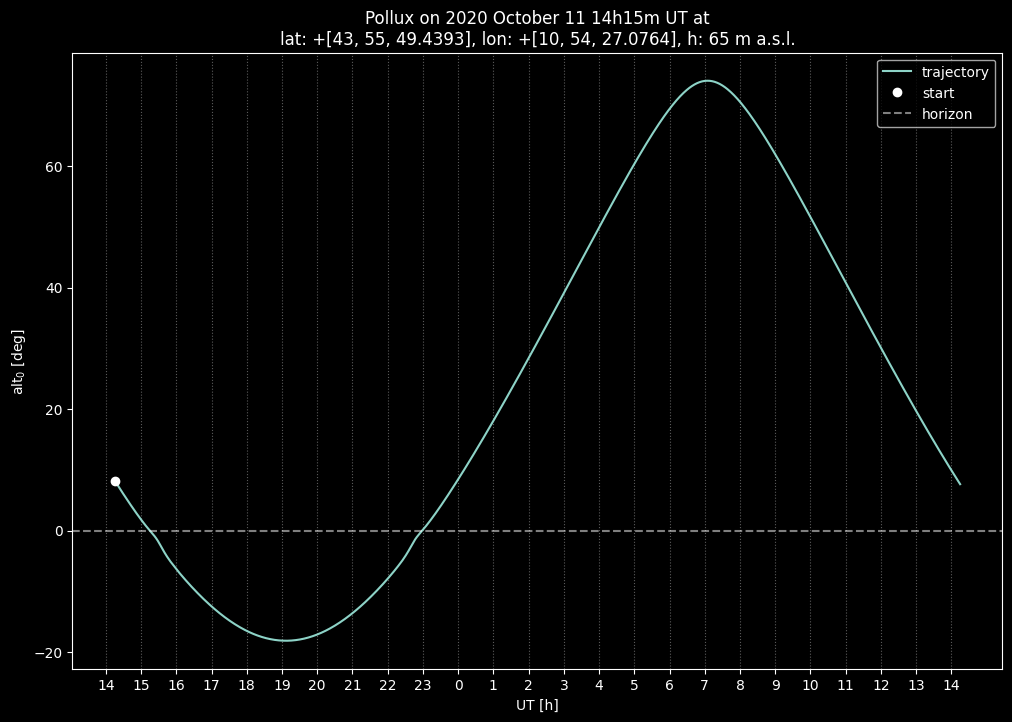

In [16]:
numpoint = 1000

lat = 43.93039980730644
lon = 10.907521220934262 
h = 65
obs = GeoPos(lon,lat,h)

name, ra, dec, prmt = import_data('targets.csv',sel=4)
obj = StarObj(name,[ra,dec],prmt)
obj.obj_info()
print()

date = Date([2020,10,11],[14,15,0])
print('Observation on ' + date.print_date())
alt, dayrange = trajectory(date,obs,obj,numpoint) 

## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar,epoch=date.epoch)

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
plt.title(obj.name + ' on ' + date.print_date() + f" at\nlat: {obs.lat.print_angle('deg')}, lon: {obs.lon.print_angle('deg')}, h: {obs.h} m a.s.l.")

plt.plot(dayrange,alt.deg,label='trajectory')
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')

plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,np.round(ticks.time.hour(),0).astype(int))
plt.xlabel('UT [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)

plt.show()

### <a id='toc1_3_3_'></a>[III.2.5 Transit, rising and setting](#toc0_)

In [15]:
def tran_ris_set(date: Date, obs_pos: GeoPos, obj: StarObj, results: bool = False, iter: int = 3) -> Time:
        date = date.copy()
        lon = obs_pos.lon
        lat = obs_pos.lat
        h0 = refraction_corr(Angles(0.,'deg',lim=90),obs_pos.h, alt0=True)

        tmpdate = Date(date.date,0.)
        Dt = time_correction(tmpdate.date[0])
        GHA = mean_Green_HA(tmpdate)
        
        tmpdate = Date(date.date,0.,timetype='TD')
        jd = tmpdate.jd
        a1, d1 = obj.coor_in_date(tmpdate-1)
        a2, d2 = obj.coor_in_date(tmpdate)
        a3, d3 = obj.coor_in_date(tmpdate+1)
        del tmpdate

        cosH0 = (np.sin(h0.rad) - np.sin(lat.rad)*np.sin(d2.rad)) / (np.cos(lat.rad)*np.cos(d2.rad))
        
        # transit
        mt = (a2 + lon - GHA).deg / 360        
        for k in range(iter):
            if abs(mt) > 1:
                mt -= np.sign(mt)
            elif mt < 0:
                mt += 1
            LST = GHA.deg + 360.985647*mt
            if LST > 360:
                LST -= 360*(LST//360)
            LST = HAngles(LST,'deg')
            n = mt + Dt/Time.DAYSEC
            a = interpole_three([a1.deg,a2.deg,a3.deg],n+jd,[jd-1,jd,jd+1])
            a = HAngles(a,'deg')
            H = LST - lon - a
            Dmt = - H.deg/360
            mt += Dmt
            if abs(mt) > 1:
                mt -= np.sign(mt)
            elif mt < 0:
                mt += 1

        time = date.time
        if mt*24 < time.hour():
            mt += 1
        m = Time(mt*Time.DAYSEC)

        if results:
            print()
            transit = Date(date.date,m,calendar=date.calendar,epoch=date.epoch)
            print('transit:\t' + transit.print_date())

        # rising and setting
        if abs(cosH0) <= 1:
            H0 = HAngles(np.arccos(cosH0),'rad',lim=180)
            mr = mt - H0.deg/360
            ms = mt + H0.deg/360
            m = np.array([mr,ms])
            for k in range(iter):
                m = np.where(abs(m) > 1, m-np.sign(m), m)
                m = np.where(m < 0, m+1, m)
                LST = GHA.deg + 360.985647*m
                LST = np.where(LST > 360, LST - 360*(LST//360), LST)               
                LST = HAngles(LST,'deg')
                n = m + Dt/Time.DAYSEC
                a = np.array([interpole_three([a1.deg,a2.deg,a3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                a = HAngles(a,'deg')
                d = np.array([interpole_three([d1.deg,d2.deg,d3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                d = HAngles(d,'deg',lim=90) 
                H = LST - lon - a
                h = np.arcsin(np.sin(lat.rad)*np.sin(d.rad) + np.cos(lat.rad)*np.cos(d.rad)*np.cos(H.rad))
                h = Angles(h,'rad',lim=90)
                Dm = (h-h0).deg / (360 * (np.cos(d.rad)*np.cos(lat.rad)*np.sin(H.rad)))
                m += Dm
                m = np.where(abs(m) > 1, m-np.sign(m), m)
                m = np.where(m < 0, m+1, m)
            
            m = np.where(m*24 < time.hour(), m+1, m)
            m = Time(m*Time.DAYSEC)
            
            if results:
                mr, ms = m.val
                rising  = Date(date.date,Time(mr),calendar=date.calendar,epoch=date.epoch)
                setting = Date(date.date,Time(ms),calendar=date.calendar,epoch=date.epoch)

                event = [rising,setting]
                names = ['rising ','setting']
                for i in range(2):
                    print(names[i] + ':\t' + event[i].print_date())
            m.val = np.append(mt*Time.DAYSEC,m.val)
        return m



transit:	2020 October 12 7h8m49.0570s UT
rising :	2020 October 11 22h58m54.8163s UT
setting:	2020 October 11 15h14m47.3991s UT


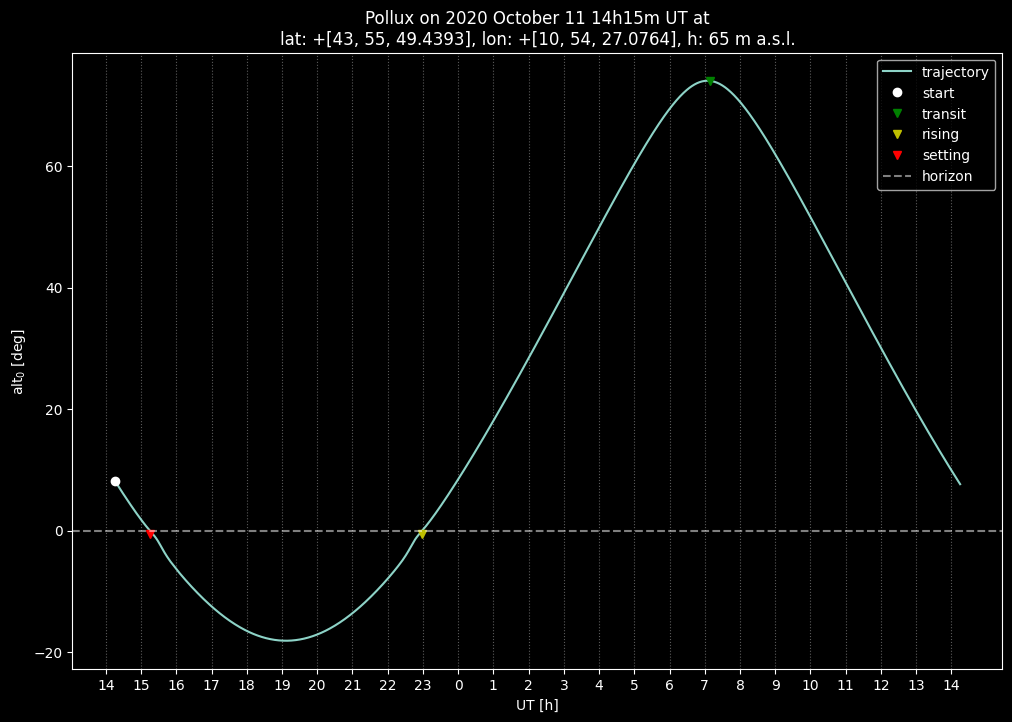

In [17]:
m = tran_ris_set(date,obs,obj,True)
event = Date(date.date,m)
ealt = compute_alt(event,obs,obj)


## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar,epoch=date.epoch)

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
plt.title(obj.name + ' on ' + date.print_date() + f" at\nlat: {obs.lat.print_angle('deg')}, lon: {obs.lon.print_angle('deg')}, h: {obs.h} m a.s.l.")

plt.plot(dayrange,alt.deg,label='trajectory')
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')
if type(m.val) != np.ndarray:
    plt.plot(event.jd,ealt.deg,'vg',label='transit')
else:
    plt.plot(event.jd[0],ealt.deg[0],'vg',label='transit')
    plt.plot(event.jd[1],ealt.deg[1],'vy',label='rising')
    plt.plot(event.jd[2],ealt.deg[2],'vr',label='setting')


plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,np.round(ticks.time.hour(),0).astype(int))
plt.xlabel('UT [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)

plt.show()


## <a id='toc1_4_'></a>[IV. Sun](#toc0_)

### <a id='toc1_4_1_'></a>[IV.I Twilight](#toc0_)

## <a id='toc1_5_'></a>[V. Moon](#toc0_)

### <a id='toc1_5_1_'></a>[V.I Moon Phases](#toc0_)